In [1]:
import numpy as np
import matplotlib.pyplot as plt
from math import exp
import networkx as nx
import seaborn as sns
from scipy.signal import find_peaks
from scipy.stats import wasserstein_distance
import copy

In [2]:
def create_plot_network(G,N,opinions,vmin,vmax,figtitle,simstr,savef=False):
# Create network for visualization
    edges=[]
    for i in range(N):
        for j in range(i):
            if G[i,j]==1:
                edges.append((i,j))

    cmap = plt.cm.viridis # plt.cm.hot #
    G2 = nx.Graph()
    G2.add_nodes_from(np.arange(0,N))
    G2.add_edges_from(edges)
    pos = nx.spring_layout(G2,seed=10)    
    
 
    plt.figure()
    edgesdraw = nx.draw_networkx_edges(G2, pos, alpha=0.4)
    nodesdraw = nx.draw_networkx_nodes(G2, pos, node_color=opinions, cmap=cmap, node_size=50, vmin=vmin, vmax=vmax)
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin = vmin, vmax=vmax))
    sm._A = []
    cbar = plt.colorbar(sm)
    cbar.ax.tick_params(labelsize=15)
    #plt.title(figtitle)
    if savef:
        plt.savefig('figs_fig1/' + simstr + figtitle + '.png',dpi=600)

In [3]:
def OD(G,N,opinions,values,simstr,nrtime,dist_removelink,prob_removelink,tries_createlink,
       maxnb,dist_createlink,prob_createlink,tries_valuechange,rate_valuechange,
       tries_opinionchange,stubbornness,persuasiveness,distcd,T):
       
    titleplot= 'time = 0' 
    create_plot_network(G, N, opinions, -1, 1, titleplot, simstr, savef=True)
    plt.show()
    plt.close('all')
    
    dist_opinions=np.zeros(200) # how many iterations used to say that the system has become stable
    dist_opinions[-1]=1
    k=0
    
    
    while (not all(dist_opinions<0.003) and k < nrtime):
        temp_opinion=copy.deepcopy(opinions)
        # step 1: remove neighbors with opdiff>0.5 
        for ind in range(N):
            opnb = opinions*G[ind] # opinions of neighbors
            myop = opinions[ind]*G[ind] #agent's own opinion at location of neighbors
            distop = abs(myop - opnb) # distance of agent's opinion to it's neighbors
            idx=np.where(distop>dist_removelink)[0] # locations where opinion distance higher than dist_removelink
            for j in range(len(idx)):
                if (np.random.uniform(0,1)<prob_removelink and sum(G[ind])>1 and sum(G[idx[j]])>1):
                    G[ind,idx[j]]=0
                    G[idx[j],ind]=0
                    
            # step 2: make new connections
            for j in range(tries_createlink):
                if sum(G[ind])<maxnb:
                    newnb=np.random.randint(0,N) # possible new neighbor
                    while (newnb == ind):
                        newnb=np.random.randint(0,N) # don't pick yourself
                    if abs(opinions[newnb]-opinions[ind])<dist_createlink and G[ind,newnb]==0 and sum(G[newnb]<maxnb):
                        if np.random.uniform(0,1)<prob_createlink:
                            G[ind, newnb] = 1
                            G[newnb, ind] = 1
        
        # step 3: change values
        for j in range(tries_valuechange):
            ind = np.random.randint(0,N)
            valnb = values*G[ind]
            optval = sum(valnb)/sum(abs(valnb)>0)
            distval = optval - values[ind]
            values[ind] = values[ind] + rate_valuechange * distval
                    
        # step 4: change opinions
        for j in range(tries_opinionchange): #2        
            ind = np.random.randint(0,N)
            if np.random.rand() < 1-stubbornness[ind]: # go into opinion-change procedure dependent on stubbornness
                randnew = np.random.rand(1)*2-1 # random new opinion
                opnb = opinions*G[ind] # opinion of neighbors
                distnb=abs(values-values[ind]) #value distance to neighbors
                valuesigns = (G[ind]*[distnb>distcd])[0]*2 # 2 if distnb > distcd, 0 if distnb < distcd
                Eold = sum(abs(valuesigns-abs(opinions[ind]*G[ind] - opnb))*persuasiveness) 
                Enew = sum(abs(valuesigns-abs(randnew*G[ind] - opnb))*persuasiveness)
                dH = Enew - Eold
                if dH < 0:
                    opinions[ind] = randnew
                elif np.random.rand() < exp(-dH/T):
                    opinions[ind]  = randnew
        
        dist_opinions[:-1] = dist_opinions[1::]
        dist_opinions[-1] = wasserstein_distance(opinions,temp_opinion)
                     
        k += 1
        
    titleplot= 'time = ' + str(k)
    create_plot_network(G, N, opinions, -1, 1, titleplot, simstr, savef=True)
    plt.show()
    plt.close('all')
            
    plt.figure()
    my_kde = sns.kdeplot(data=opinions, bw_adjust=0.9)
    plt.xlim(-1,1)
    plt.xlabel('opinions')
    line = my_kde.lines[0]
    x, y = line.get_data()
    nrpeaks = len(find_peaks(y,height=max(y)/10,prominence=0.1)[0])
    if nrpeaks==1:
        if np.var(opinions)<0.05:
            categories=0
        else:
            categories=1
    elif nrpeaks==2:
        categories=2
    else:
        categories=3
    plt.savefig('figs_fig1/dist' + simstr + titleplot + '.png')
    plt.show()
    plt.close('all')
    return opinions, G, categories, dist_opinions

# Finding nice visualizations for category A by trial and error

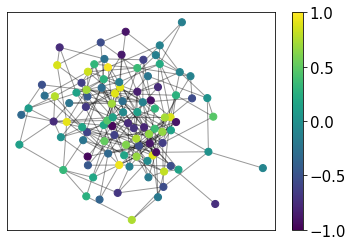

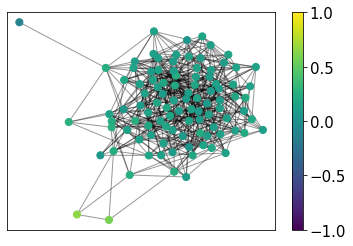

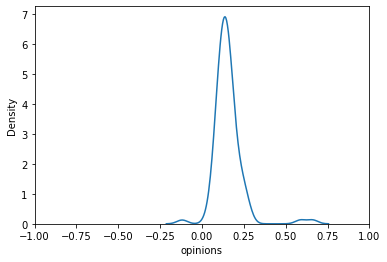

0


In [4]:
np.random.seed(4)

#Initialization
N=100
stubbornness = np.random.rand(N) 
persuasiveness = np.random.rand(N) 
opinions = np.random.rand(N)*2-1
values = np.random.rand(N)*2-1 

# set parameters
simstr='catA1'
nrtime=100
dist_removelink = 0.6
prob_removelink = 0.02 
tries_createlink = 10 
dist_createlink = 0.1 
prob_createlink = 0.02 
maxnb = 10 
tries_valuechange = 10
rate_valuechange = 0.05
tries_opinionchange = 150
distcd=2
T=0.1

G=np.zeros((N,N))
for i in range(N):
    for j in range(i):
        if (np.random.uniform(0,1)<0.05 and sum(G[i])<maxnb and sum(G[j])<maxnb):
            G[i,j]=1
            G[j,i]=1
nonb=np.where(sum(G)<0.1)[0]
for i in range(len(nonb)):
    G[nonb[i],nonb[i]-1] = 1
    G[nonb[i]-1,nonb[i]] = 1

opinions1, G, categories, dist_opinions = OD(G,N,opinions,values,simstr,nrtime,dist_removelink,prob_removelink,tries_createlink,
       maxnb,dist_createlink,prob_createlink,tries_valuechange,rate_valuechange,
       tries_opinionchange,stubbornness,persuasiveness,distcd,T)
print(categories)

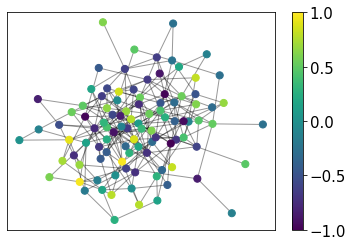

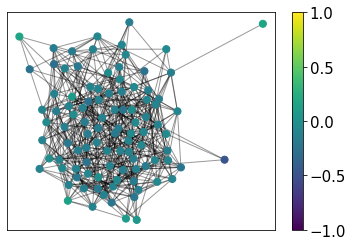

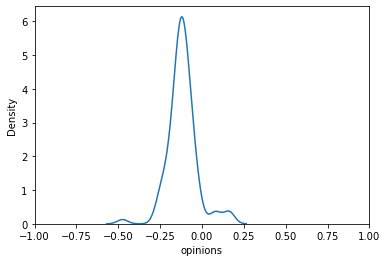

0


In [5]:
np.random.seed(5)

#Initialization
N=100
stubbornness = np.random.rand(N) 
persuasiveness = np.random.rand(N) 
opinions = np.random.rand(N)*2-1
values = np.random.rand(N)*2-1 

# set parameters
simstr='catA2'
nrtime=200
dist_removelink = 0.6
prob_removelink = 0.01 
tries_createlink = 10 
dist_createlink = 0.1 
prob_createlink = 0.01 
maxnb = 10 
tries_valuechange = 10
rate_valuechange = 0.05
tries_opinionchange = 150
distcd=2
T=0.2

G=np.zeros((N,N))
for i in range(N):
    for j in range(i):
        if (np.random.uniform(0,1)<0.05 and sum(G[i])<maxnb and sum(G[j])<maxnb):
            G[i,j]=1
            G[j,i]=1
nonb=np.where(sum(G)<0.1)[0]
for i in range(len(nonb)):
    G[nonb[i],nonb[i]-1] = 1
    G[nonb[i]-1,nonb[i]] = 1
    
stubbornness[np.random.choice(N,10)]=0.9

opinions2, G, categories, dist_opinions = OD(G,N,opinions,values,simstr,nrtime,dist_removelink,prob_removelink,tries_createlink,
       maxnb,dist_createlink,prob_createlink,tries_valuechange,rate_valuechange,
       tries_opinionchange,stubbornness,persuasiveness,distcd,T)
print(categories)

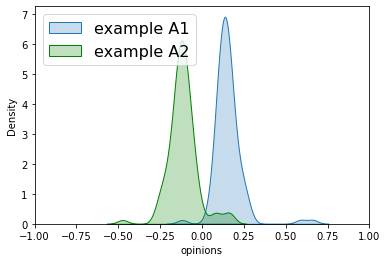

In [6]:
plt.figure()
my_kde = sns.kdeplot(data=opinions1, bw_adjust=0.9, shade=True, label='example A1')
my_kde = sns.kdeplot(data=opinions2, bw_adjust=0.9, color='green', shade=True, label='example A2')
plt.xlim(-1,1)
plt.xlabel('opinions')
plt.legend(prop={'size': 16},loc=2)
plt.savefig('figs_fig1/dist_A.png')

# Finding nice visualizations for category B by trial and error

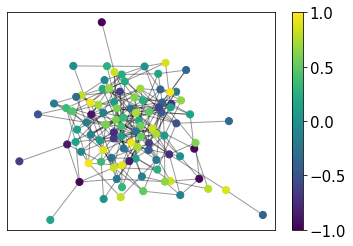

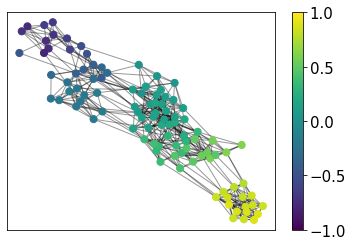

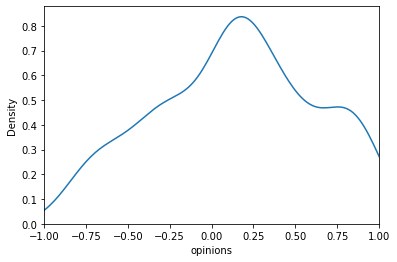

1


In [7]:
np.random.seed(1)

#Initialization
N=100
stubbornness = np.random.rand(N) 
persuasiveness = np.random.rand(N) 
opinions = np.random.rand(N)*2-1
values = np.random.rand(N)*2-1 

# set parameters
simstr='catB1'
nrtime=2000
dist_removelink = 0.6
prob_removelink = 0.02 
tries_createlink = 10 
dist_createlink = 0.1 
prob_createlink = 0.02 
maxnb = 10 
tries_valuechange = 10
rate_valuechange = 0.05
tries_opinionchange = 5
distcd=2
T=0.01

G=np.zeros((N,N))
for i in range(N):
    for j in range(i):
        if (np.random.uniform(0,1)<0.05 and sum(G[i])<maxnb and sum(G[j])<maxnb):
            G[i,j]=1
            G[j,i]=1
nonb=np.where(sum(G)<0.1)[0]
for i in range(len(nonb)):
    G[nonb[i],nonb[i]-1] = 1
    G[nonb[i]-1,nonb[i]] = 1

opinions3, G, categories, dist_opinions = OD(G,N,opinions,values,simstr,nrtime,dist_removelink,prob_removelink,tries_createlink,
       maxnb,dist_createlink,prob_createlink,tries_valuechange,rate_valuechange,
       tries_opinionchange,stubbornness,persuasiveness,distcd,T)
print(categories)

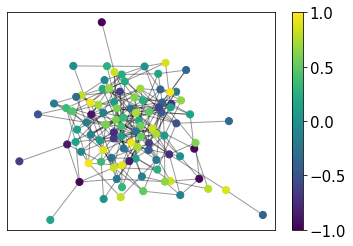

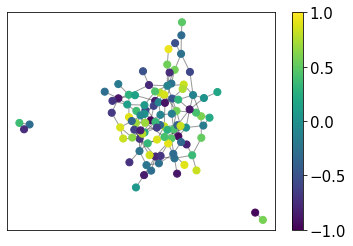

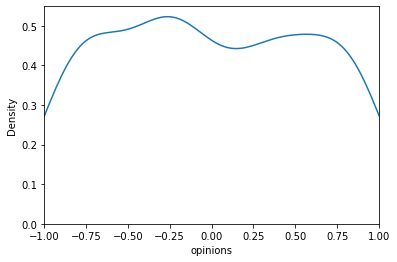

1


In [8]:
np.random.seed(1)

#Initialization
N=100
stubbornness = np.random.rand(N) 
persuasiveness = np.random.rand(N) 
opinions = np.random.rand(N)*2-1
values = np.random.rand(N)*2-1 

# set parameters
simstr='catB2'
nrtime=2000
dist_removelink = 0.6
prob_removelink = 0.1 
tries_createlink = 10 
dist_createlink = 0.1 
prob_createlink = 0.1
maxnb = 10 
tries_valuechange = 10
rate_valuechange = 0.05
tries_opinionchange = 100
distcd=2
T=10

G=np.zeros((N,N))
for i in range(N):
    for j in range(i):
        if (np.random.uniform(0,1)<0.05 and sum(G[i])<maxnb and sum(G[j])<maxnb):
            G[i,j]=1
            G[j,i]=1
nonb=np.where(sum(G)<0.1)[0]
for i in range(len(nonb)):
    G[nonb[i],nonb[i]-1] = 1
    G[nonb[i]-1,nonb[i]] = 1

opinions4, G, categories, dist_opinions = OD(G,N,opinions,values,simstr,nrtime,dist_removelink,prob_removelink,tries_createlink,
       maxnb,dist_createlink,prob_createlink,tries_valuechange,rate_valuechange,
       tries_opinionchange,stubbornness,persuasiveness,distcd,T)
print(categories)

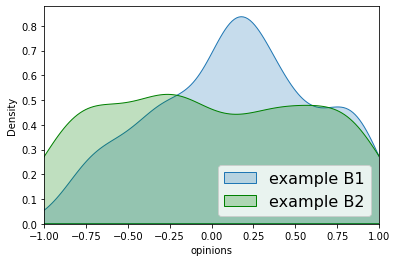

In [9]:
plt.figure()
my_kde = sns.kdeplot(data=opinions3, bw_adjust=0.9, shade=True, label='example B1')
my_kde = sns.kdeplot(data=opinions4, bw_adjust=0.9, color='green', shade=True, label='example B2')
plt.xlim(-1,1)
plt.xlabel('opinions')
plt.legend(prop={'size': 16},loc=4)
plt.savefig('figs_fig1/dist_B.png')

# Finding nice visualizations for category C by trial and error

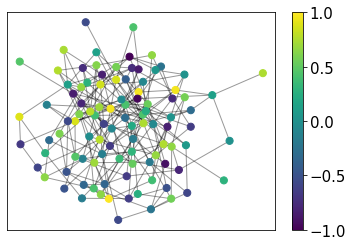

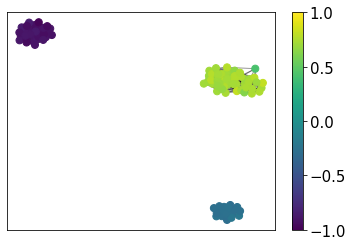

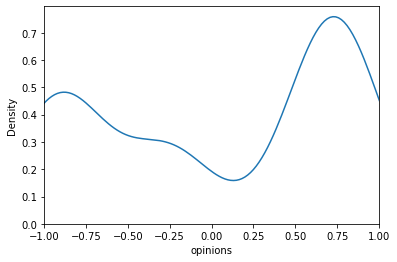

2


In [10]:
np.random.seed(2)

#Initialization
N=100
stubbornness = np.random.rand(N) 
persuasiveness = np.random.rand(N) 
opinions = np.random.rand(N)*2-1
values = np.random.rand(N)*2-1 

# set parameters
simstr='catC1'
nrtime=1000
dist_removelink = 0.6
prob_removelink = 0.2 
tries_createlink = 10 
dist_createlink = 0.1 
prob_createlink = 0.2
maxnb = 10 
tries_valuechange = 10
rate_valuechange = 0.05
tries_opinionchange = 150
distcd=0.5
T=0.1

G=np.zeros((N,N))
for i in range(N):
    for j in range(i):
        if (np.random.uniform(0,1)<0.05 and sum(G[i])<maxnb and sum(G[j])<maxnb):
            G[i,j]=1
            G[j,i]=1
nonb=np.where(sum(G)<0.1)[0]
for i in range(len(nonb)):
    G[nonb[i],nonb[i]-1] = 1
    G[nonb[i]-1,nonb[i]] = 1

opinions5, G, categories, dist_opinions = OD(G,N,opinions,values,simstr,nrtime,dist_removelink,prob_removelink,tries_createlink,
       maxnb,dist_createlink,prob_createlink,tries_valuechange,rate_valuechange,
       tries_opinionchange,stubbornness,persuasiveness,distcd,T)
print(categories)

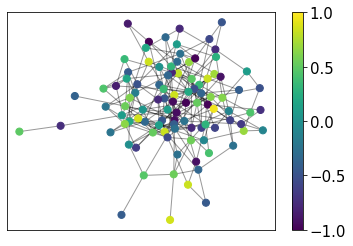

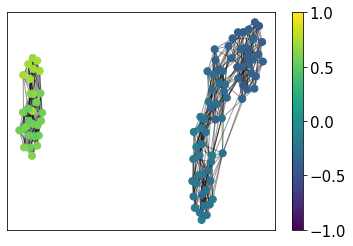

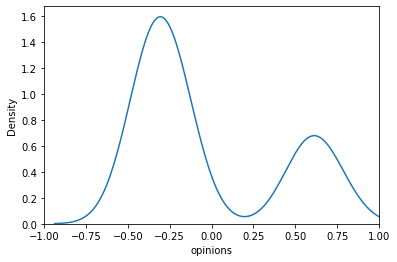

2


In [11]:
np.random.seed(9)

#Initialization
N=100
stubbornness = np.random.rand(N) 
persuasiveness = np.random.rand(N) 
opinions = np.random.rand(N)*2-1
values = np.random.rand(N)*2-1 

# set parameters
simstr='catC2'
nrtime=750
dist_removelink = 0.6
prob_removelink = 0.2 
tries_createlink = 10 
dist_createlink = 0.1 
prob_createlink = 0.2
maxnb = 10 
tries_valuechange = 10
rate_valuechange = 0.05
tries_opinionchange = 150
distcd=2
T=0.1

G=np.zeros((N,N))
for i in range(N):
    for j in range(i):
        if (np.random.uniform(0,1)<0.05 and sum(G[i])<maxnb and sum(G[j])<maxnb):
            G[i,j]=1
            G[j,i]=1
nonb=np.where(sum(G)<0.1)[0]
for i in range(len(nonb)):
    G[nonb[i],nonb[i]-1] = 1
    G[nonb[i]-1,nonb[i]] = 1

opinions6, G, categories, dist_opinions = OD(G,N,opinions,values,simstr,nrtime,dist_removelink,prob_removelink,tries_createlink,
       maxnb,dist_createlink,prob_createlink,tries_valuechange,rate_valuechange,
       tries_opinionchange,stubbornness,persuasiveness,distcd,T)
print(categories)

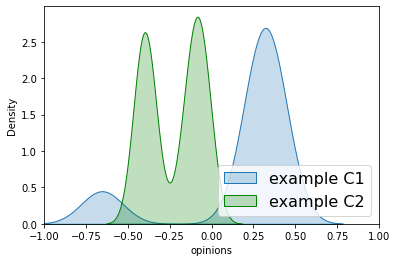

In [127]:
plt.figure()
my_kde = sns.kdeplot(data=opinions5, bw_adjust=0.9, shade=True, label='example C1')
my_kde = sns.kdeplot(data=opinions6, bw_adjust=0.9, color='green', shade=True, label='example C2')
plt.xlim(-1,1)
plt.xlabel('opinions')
plt.legend(prop={'size': 16},loc=4)
plt.savefig('figs_fig1/dist_C.png')

# Finding nice visualizations for category D by trial and error

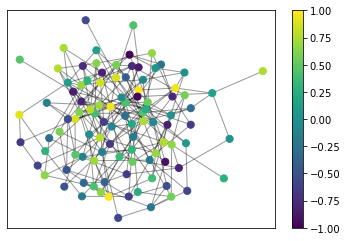

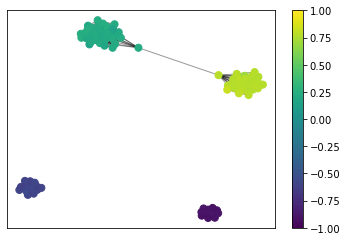

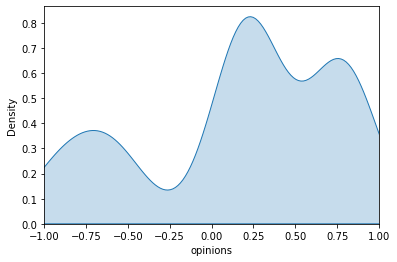

2


In [84]:
np.random.seed(2) 

#Initialization
N=100
stubbornness = np.random.rand(N) 
persuasiveness = np.random.rand(N) 
opinions = np.random.rand(N)*2-1
values = np.random.rand(N)*2-1 

# set parameters
simstr='catD1'
nrtime=2000
dist_removelink = 0.6
prob_removelink = 0.2 
tries_createlink = 10 
dist_createlink = 0.1 
prob_createlink = 0.2
maxnb = 10 
tries_valuechange = 10
rate_valuechange = 0.05
tries_opinionchange = 100
distcd=0.1
T=0.05

G=np.zeros((N,N))
for i in range(N):
    for j in range(i):
        if (np.random.uniform(0,1)<0.05 and sum(G[i])<maxnb and sum(G[j])<maxnb):
            G[i,j]=1
            G[j,i]=1
nonb=np.where(sum(G)<0.1)[0]
for i in range(len(nonb)):
    G[nonb[i],nonb[i]-1] = 1
    G[nonb[i]-1,nonb[i]] = 1

opinions6, G, categories, dist_opinions = OD(G,N,opinions,values,simstr,nrtime,dist_removelink,prob_removelink,tries_createlink,
       maxnb,dist_createlink,prob_createlink,tries_valuechange,rate_valuechange,
       tries_opinionchange,stubbornness,persuasiveness,distcd,T)
print(categories)

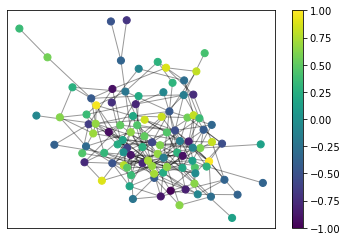

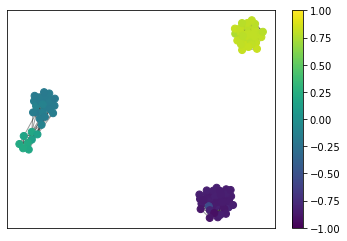

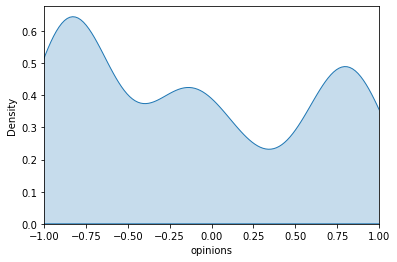

3


In [112]:
np.random.seed(6) 

#Initialization
N=100
stubbornness = np.random.rand(N) 
persuasiveness = np.random.rand(N) 
opinions = np.random.rand(N)*2-1
values = np.random.rand(N)*2-1 

# set parameters
simstr='catD1'
nrtime=2000
dist_removelink = 0.6
prob_removelink = 0.2 
tries_createlink = 10 
dist_createlink = 0.1 
prob_createlink = 0.2
maxnb = 10 
tries_valuechange = 10
rate_valuechange = 0.05
tries_opinionchange = 100
distcd=0.1
T=0.05

G=np.zeros((N,N))
for i in range(N):
    for j in range(i):
        if (np.random.uniform(0,1)<0.05 and sum(G[i])<maxnb and sum(G[j])<maxnb):
            G[i,j]=1
            G[j,i]=1
nonb=np.where(sum(G)<0.1)[0]
for i in range(len(nonb)):
    G[nonb[i],nonb[i]-1] = 1
    G[nonb[i]-1,nonb[i]] = 1

opinions7, G, categories, dist_opinions = OD(G,N,opinions,values,simstr,nrtime,dist_removelink,prob_removelink,tries_createlink,
       maxnb,dist_createlink,prob_createlink,tries_valuechange,rate_valuechange,
       tries_opinionchange,stubbornness,persuasiveness,distcd,T)
print(categories)

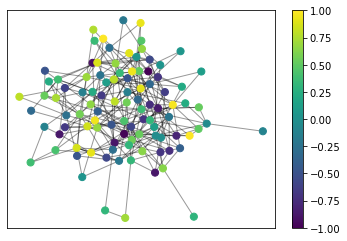

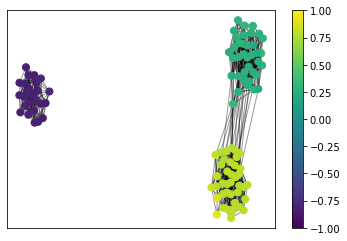

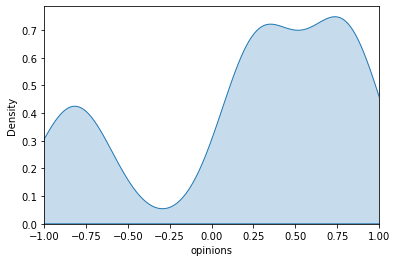

3


In [113]:
np.random.seed(17) #14

#Initialization
N=100
stubbornness = np.random.rand(N) 
persuasiveness = np.random.rand(N) 
opinions = np.random.rand(N)*2-1
values = np.random.rand(N)*2-1 

# set parameters
simstr='catD1'
nrtime=2000
dist_removelink = 0.6
prob_removelink = 0.2 
tries_createlink = 10 
dist_createlink = 0.1 
prob_createlink = 0.2
maxnb = 10 
tries_valuechange = 10
rate_valuechange = 0.05
tries_opinionchange = 100
distcd=0.1
T=0.05

G=np.zeros((N,N))
for i in range(N):
    for j in range(i):
        if (np.random.uniform(0,1)<0.05 and sum(G[i])<maxnb and sum(G[j])<maxnb):
            G[i,j]=1
            G[j,i]=1
nonb=np.where(sum(G)<0.1)[0]
for i in range(len(nonb)):
    G[nonb[i],nonb[i]-1] = 1
    G[nonb[i]-1,nonb[i]] = 1

opinions8, G, categories, dist_opinions = OD(G,N,opinions,values,simstr,nrtime,dist_removelink,prob_removelink,tries_createlink,
       maxnb,dist_createlink,prob_createlink,tries_valuechange,rate_valuechange,
       tries_opinionchange,stubbornness,persuasiveness,distcd,T)
print(categories)

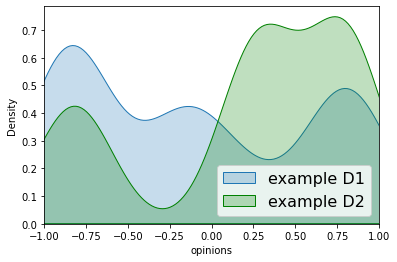

In [128]:
plt.figure()
my_kde = sns.kdeplot(data=opinions7, bw_adjust=0.9, shade=True, label='example D1')
my_kde = sns.kdeplot(data=opinions8, bw_adjust=0.9, color='green', shade=True, label='example D2')
plt.xlim(-1,1)
plt.xlabel('opinions')
plt.legend(prop={'size': 16},loc=4)
plt.savefig('figs_fig1/dist_D.png')

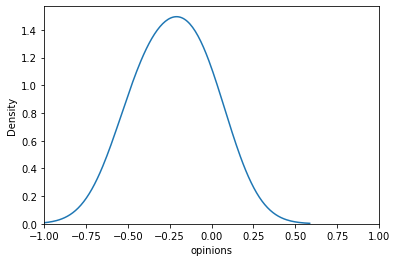

In [131]:
plt.figure()
my_kde = sns.kdeplot(data=opinions, bw_adjust=0.9)
plt.xlim(-1,1)
plt.xlabel('opinions')
line = my_kde.lines[0]
x, y = line.get_data()
nrpeaks = len(find_peaks(y,height=max(y)/10,prominence=0.1)[0])
if nrpeaks==1:
    if np.var(opinions)<0.05:
        categories=0
    else:
        categories=1
elif nrpeaks==2:
    categories=2
else:
    categories=3

In [96]:
nrpeaks = len(find_peaks(y,height=max(y)/10,prominence=0.1)[0])
print(nrpeaks)

3


In [87]:
categories

2

In [88]:
find_peaks(y,height=max(y)/10,prominence=0.001)

(array([ 55, 118, 153], dtype=int64),
 {'peak_heights': array([0.37154631, 0.82476199, 0.65827023]),
  'prominences': array([0.23711221, 0.82132823, 0.08983018]),
  'left_bases': array([  0,   0, 138], dtype=int64),
  'right_bases': array([ 85, 199, 199], dtype=int64)})